In [1]:
%matplotlib notebook
import sys
sys.path.append('..')
from data import load_data

from __future__ import print_function
from matplotlib.widgets import RectangleSelector
import numpy as np
import matplotlib.pyplot as plt
from lightjob.cli import load_db
import re
import h5py
import json
import pandas as pd
from lasagnekit.misc.plot_weights import dispims_color
from ipywidgets import interact, interactive, fixed
import cPickle as pickle

In [2]:
# storing global variables
class Singleton(object):
    img_plot = None
    rectangle_selector = None
    tsne_df = None
    err = []
    
# plot stuff

def plot_dataset(ax, code_2d, categories):
    colors = [
      'r',
      'b',
      'g',
      'crimson',
      'gold',
      'yellow',
      'maroon',
      'm',
      'c',
      'orange'
    ]
    for cat in range(0, 10):
        g = categories == cat
        ax.scatter(code_2d[g, 0], code_2d[g, 1],
                    marker='+', c=colors[cat], s=40, alpha=0.7,
                    label="digit {}".format(cat))

def plot_generated(ax, code_2d, categories):
    g = categories < 0
    ax.scatter(code_2d[g, 0], code_2d[g, 1], marker='+',
                c='gray', s=30)

    
# matplotlib interactive stuff
def line_select_callback(eclick, erelease):
    'eclick and erelease are the press and release events'
    try:
        x1, y1 = eclick.xdata, eclick.ydata
        x2, y2 = erelease.xdata, erelease.ydata
        w, h = 28, 28 # mnist dim
        x = np.array(Singleton.tsne_df['x'])
        y = np.array(Singleton.tsne_df['y'])
        tsne_filter = ((x >= x1) &
                       (x <= x2) &
                       (y >= y1) &
                       (y <= y2))
        tsne_df = {}
        for c in ('x', 'y', 'images'):
            tsne_df[c] = Singleton.tsne_df[c][tsne_filter]
        if len(tsne_df['x']) == 0:
            Singleton.img_plot.set_data(Singleton.img_plot.get_array() * 0)
            return
        samples = tsne_df['images']
        samples = samples.reshape((samples.shape[0], w, h, 1)) * np.ones((1, 1, 1, 3))
        img = dispims_color(samples, border=1, bordercolor=(10, 10, 10))
        Singleton.img_plot.set_data(img)
    except Exception as ex:
        Singleton.err.append(str(ex))

def toggle_selector(event):
    if event.button:
        Singleton.img_plot.set_data(Singleton.img_plot.get_array() * 0)
    if event.key in ['Q', 'q'] and toggle_selector.RS.active:
        sys.stdout.flush()
        Singleton.rectangle_selector.set_active(False)
        Singleton.img_plot.set_data(Singleton.img_plot.get_array() * 0)
    if event.key in ['A', 'a'] and not toggle_selector.RS.active:
        sys.stdout.flush()
        Singleton.rectangle_selector.set_active(True)
        Singleton.img_plot.set_data(Singleton.img_plot.get_array() * 0)

# job retrieval
def retrieve_job(pattern, db):
    J = db.jobs_with(state='success', type='generation')
    
    J = filter(lambda j: re.match(pattern, j['summary']), J)
    if len(J) == 0:
        raise Exception('Not found : {}'.format(pattern))
    return np.random.choice(J)

def get_full_job_id(j):
    return j['summary']

def get_data_slice(X, id_):
    js = json.loads(X.attrs[id_])
    return slice(js['start'], js['end'])

def get_df(filename):
    fd = open(filename)
    data = pickle.load(fd)
    fd.close()
    return data

In [3]:
db = load_db()

{u'backend': u'Dataset'}


In [4]:
def show(id_pattern=''):
    j = retrieve_job(id_pattern, db)
    id_ = get_full_job_id(j)

    tsne_df = get_df('../jobs/results/{}/tsne_input.pkl'.format(id_))
    Singleton.tsne_df = tsne_df

    fig = plt.figure(figsize=(15, 15))

    ax1 = plt.subplot2grid((5, 6), (0, 0), colspan=3, rowspan=2)
    ax2 = plt.subplot2grid((5, 6), (0, 3), colspan=2, rowspan=2)
    cats = tsne_df['categories'].astype(int)
    code_2d = pd.DataFrame({'x': tsne_df['x'], 'y': tsne_df['y']}).values
    plot_dataset(ax1, code_2d, cats)
    plot_generated(ax1, code_2d, cats)

    Singleton.rectangle_selector = RectangleSelector(
        ax1, line_select_callback,
        drawtype='box', useblit=True,
        button=[1, 3],  # don't use middle button
        minspanx=5, minspany=5,
        spancoords='pixels',
        interactive=True)
    img_plot = ax2.imshow(np.zeros((20, 20)), interpolation='none', cmap='gray')
    Singleton.img_plot = img_plot
    plt.connect('key_press_event', toggle_selector)
    plt.connect('button_press_event', toggle_selector)
    plt.title(id_)
    plt.tight_layout()

    plt.show()

<IPython.core.display.Javascript object>


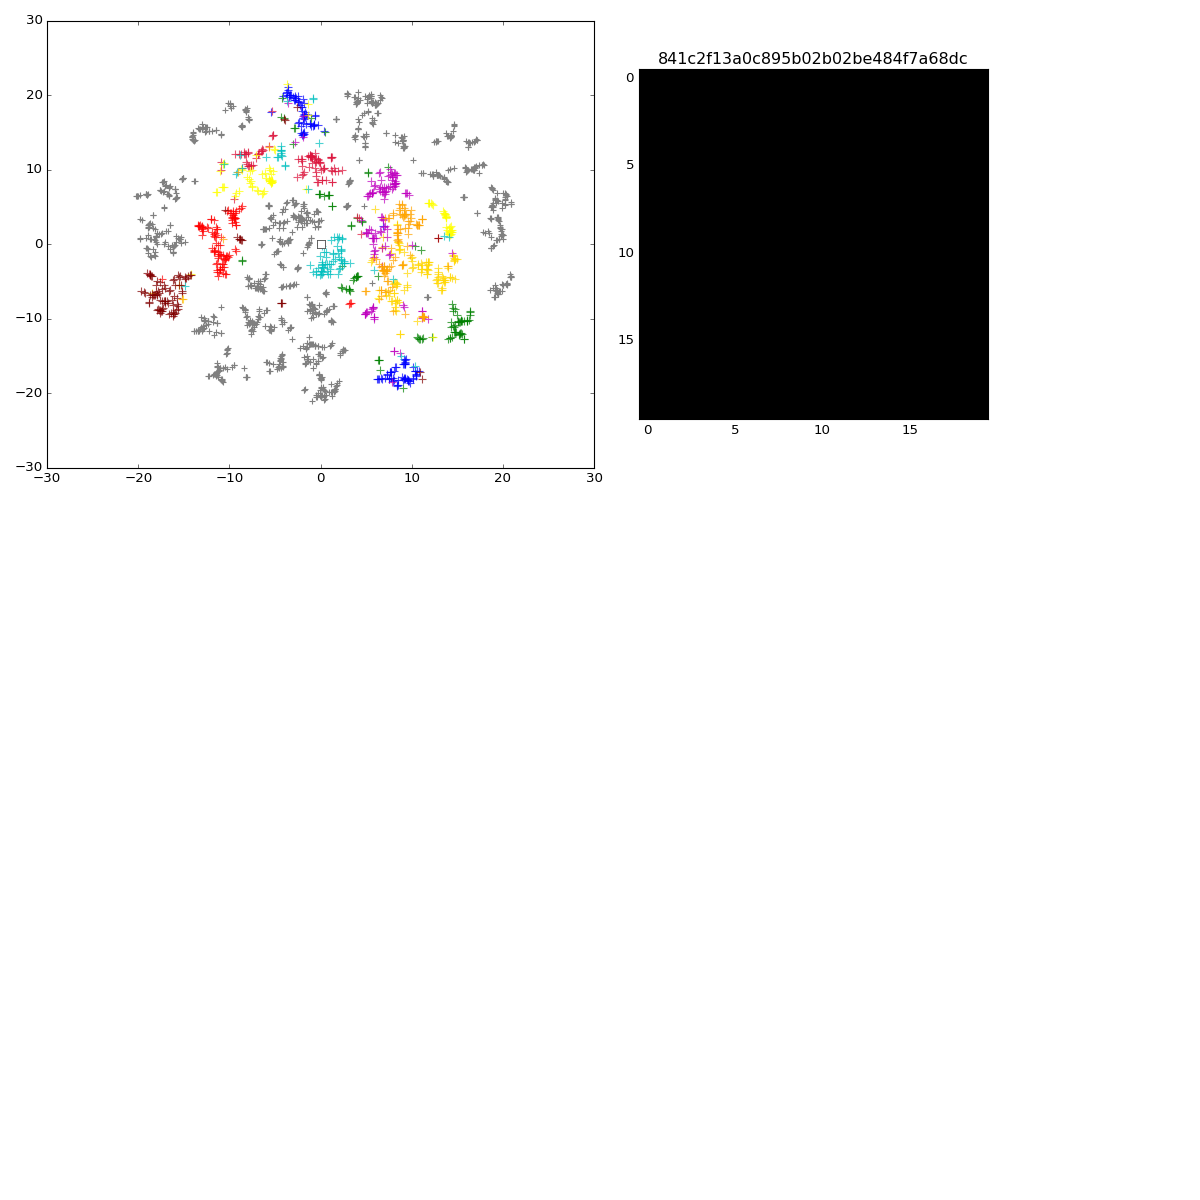

In [5]:
interact(show, __manual=True)